# 05 - Image Restoration

### Part 2 - Blur

In this notebook we deal with the problem of image deconvolution, which is often applied to reduce **blur** effect in image.

Image restoration is concerned with improving the visual quality of images by using prior knowledge about the process that degraded the image, in particular *blur* and *noise*. In contrast with image enhancement techniques - in which a method is arbitrarily selected to allow improving the quality of images - restoration usually considers the image formation process:

$$g(\mathbf{x}) = \mathcal{N} \left\lbrace f(\mathbf{x}) * h(\mathbf{x}) \right\rbrace,$$

where $g$ is the observed or acquired image, $f$ is the ideal or original image, $h$ is the filter that explain the distortion caused in the image that is defined as a *spreading* of data from a given pixel $f(\mathbf{x})$ to a neighbourhood centred in $g(\mathbf{x})$, and $\mathcal{N}$ is a stochastic process that explains the *noise* in the image $g(\mathbf{x})$.

**Image restoration** is a process to obtain an estimate $\hat{f}$ of the original image $f$.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as imageio
from scipy.fftpack import fftn, ifftn, fftshift

### Degradation function and Point Spread Function

Function $h(\mathbf{x})$ defines how the pixels are spreaded from the center to neighbour pixels. Such function guides de degradation we want to reverse when using image restoration algorithms. Such function is often called the impulse response of the imaging system, or the point spread function.

Let us build a function to create a Gaussian filter (often called kernel as well) as a way to simulate the point spread function. This function may be used to simulate the blur introduced by a acquisition system.

Note that what the image formation considers is a function that *spreads* the energy of a point to surrounding pixels, so it is indeed what a filter such as the Gaussian does. Let us take a look at the function:
$$\frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(x/\sigma)^2}$$

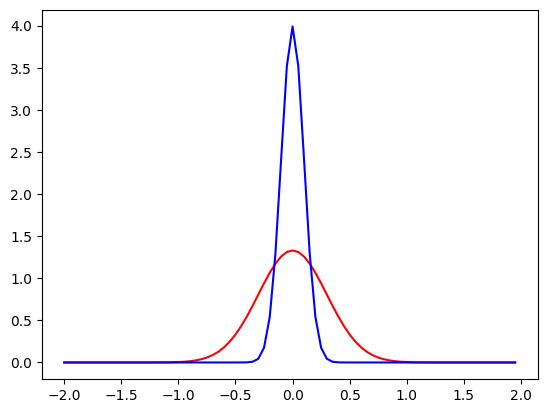

In [3]:
x = np.arange(-2,2,0.05)

# Parameter sigma is related to the dispersion of the values
sigma1 = 0.3
gauss1d_1 = (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-(np.square(x/sigma1)/2))

sigma2 = 0.1
gauss1d_2 = (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-(np.square(x/sigma2)/2))

plt.plot(x, gauss1d_1, 'r') # Larger sigma, 0.3
plt.plot(x, gauss1d_2, 'b') # Smaller sigma, 0.1

Note how the blue plot $\sigma = 0.15$ distributes the values in a region that is more concentrated around 0, while the red line defines a distribution that spreads values. By increasing $\sigma$, we approach the uniform distribution.

In order to use such function in images we need a 2D version of it, and discretized to be encoded in filters to be applied via convolution.

In [5]:
def gaussian_filter(k=5, sigma=1.0):
    ''' Gaussian filter
    :param k: defines the lateral size of the kernel/filter, default 5
    :param sigma: standard deviation (dispersion) of the Gaussian distribution
    :return matrix with a filter [k x k] to be used in convolution operations
    '''
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
    return filt / np.sum(filt)

In [6]:
g1 = gaussian_filter(k=5, sigma=0.9)
print(g1)

[[0.00141805 0.00903528 0.01675038 0.00903528 0.00141805]
 [0.00903528 0.05756927 0.10672687 0.05756927 0.00903528]
 [0.01675038 0.10672687 0.19785944 0.10672687 0.01675038]
 [0.00903528 0.05756927 0.10672687 0.05756927 0.00903528]
 [0.00141805 0.00903528 0.01675038 0.00903528 0.00141805]]


This is a symmetric function describing a radial dispersion. Note how the central value is the largest and that the remaining values decrease exponentially. This function is normalized so that its sum is one, so that to not alter the **energy** of the image when the convolution is applied.

Let us create a larger filter and plot its heatmap to show the **radial difusion** pattern

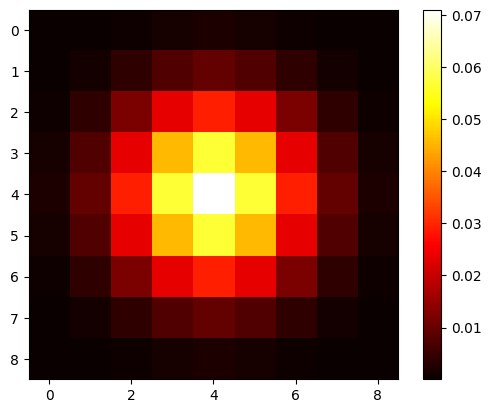

In [7]:
g2 = gaussian_filter(k=9, sigma=1.5)
plt.imshow(g2, cmap='hot', interpolation='nearest')
plt.colorbar()

### Simulating blur

In order to simulate blur, we are going to convolve an image with one of such functions using the Fourier Transform, creating an image $g$. In the Fourier domain:

$$G(\mathbf{u}) = F(\mathbf{u})H(\mathbf{u})$$

But note $H$ and $F$ must have the same size. Therefore we have to zero pad the function $h$.

Text(0.5, 1.0, 'degraded/blurred image')

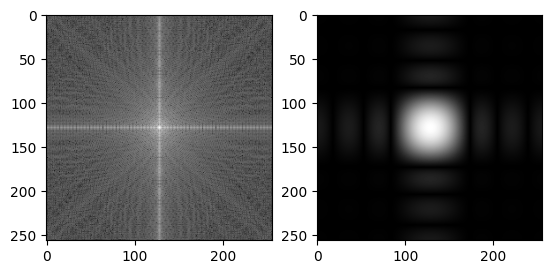

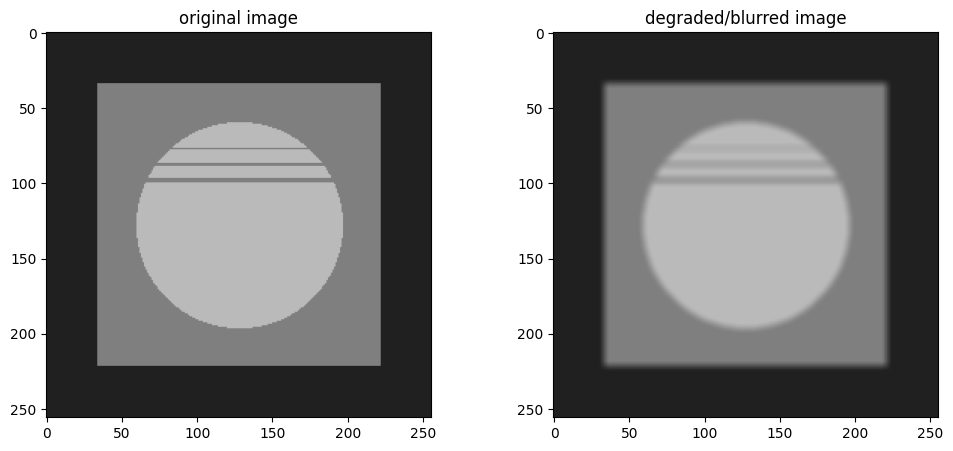

In [11]:
f = imageio.imread("Images/pattern2.png")
h = gaussian_filter(k=7, sigma=2.5)

# Computing the number of padding on one side
a = int(f.shape[0]//2 - h.shape[0]//2)
h_pad = np.pad(h, (a,a-1), 'constant', constant_values=(0))

# Computing the Fourier transforms
F = fftn(f)
H = fftn(h_pad)

plt.subplot(121)
plt.imshow(fftshift(np.log(np.abs(F)+1)), cmap="gray")
plt.subplot(122)
plt.imshow(fftshift(np.log(np.abs(H)+1)), cmap="gray")

# Convolution
G = np.multiply(F,H)

# Inverse Transform
# - we have to perform FFT shift before reconstructing the image in the space domain
g = fftshift(ifftn(G).real)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(122)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")

### Inverse filter

The inverse filter is an attempt to inverse the convolution process, obtaining an estimate of the original image $\hat{f}$

$$\hat{F}(\mathbf{u}) = \frac{G(\mathbf{u})}{H(\mathbf{u})}$$

Note that we assume knowledge about $H$, or the degradation function. Therefore we know $h$ and $g$, and want to reconstruct $f$.

Text(0.5, 1.0, 'restored image')

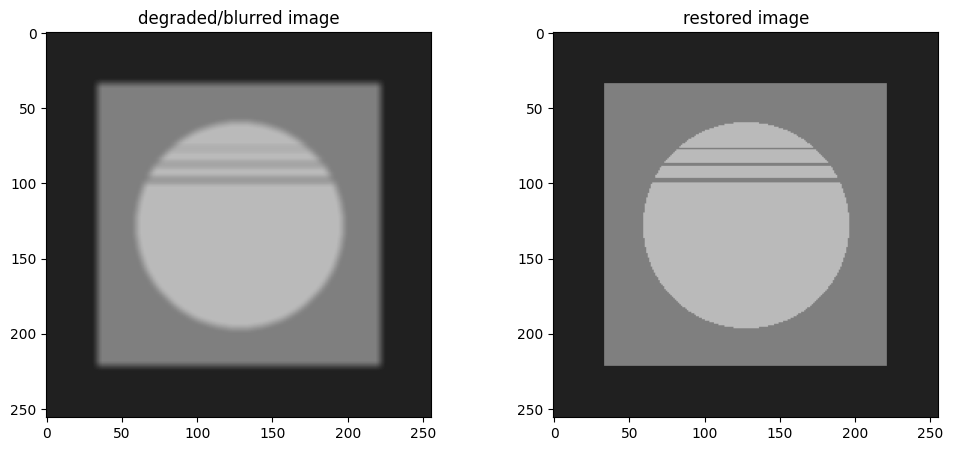

In [12]:
#F_hat = G/H
F_hat = np.divide(G,H)

f_hat = ifftn(F_hat).real

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(122)
plt.imshow(f_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")

As we can see, the results of the inverse filter are really good! However we assumed a noise-free scenario and a well behaved H function. Let us see two cases in which this would not work:

1. Ill-posed problem: when $h$ does not have an inverse, or its Fourier transform $H$ have zero coefficients, we cannot perform the inverse filter directly
2. Noise: when image is corrupted by noise, this term should be considered in the equation and would cause an amplification of the noise, since its content is mostly in the high frequency regions of the Fourier spectrum

Text(0.5, 1.0, 'noisy and blurred image')

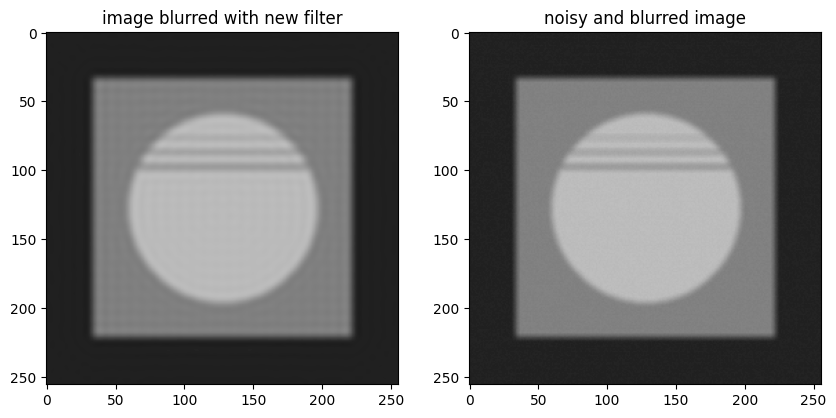

In [15]:
# 1. creating a new h and altering to contain zero and near-zero values
Hz = np.array(H,copy=True)
Hz[np.abs(H)<0.4] = 0.0001
Hz[np.abs(H)<0.2] = 0.0
h_z = ifftn(Hz).real[122:135,122:135]
h_z = h_z/np.sum(h_z)

# Now computing the degraded image
Gz = np.multiply(F , Hz) # case 1

# 2. adding noise to the image
g_noise = (g.astype(np.int32) + np.random.randint(5, size=f.shape)).astype(np.uint8)
Gn = fftn(g_noise) # taking it FFT

# Inverse Transform
# - we have to perform FFT shift before reconstructing the image in the space domain for the image that was convolved
gz = fftshift(ifftn(Gz).real)
gn = ifftn(Gn).real

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(gz, cmap="gray", vmin=0, vmax=255); plt.title("image blurred with new filter")
plt.subplot(122)
plt.imshow(gn, cmap="gray", vmin=0, vmax=255); plt.title("noisy and blurred image")

Both images look similar to the previous one, but let us try to use an inverse filter.

/tmp/ipykernel_4476/3879965693.py:11: RuntimeWarning: divide by zero encountered in divide
  Fz_hat = np.divide(Gz,Hz)
/tmp/ipykernel_4476/3879965693.py:11: RuntimeWarning: invalid value encountered in divide
  Fz_hat = np.divide(Gz,Hz)


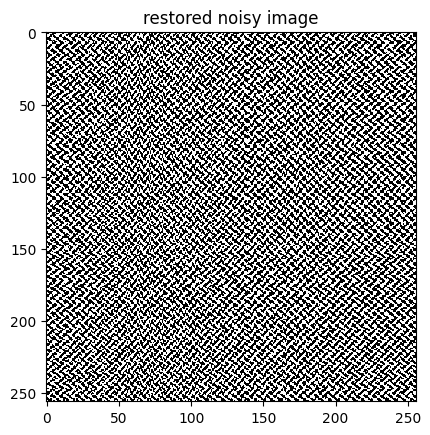

In [16]:
# Compute FFTs
Gz = fftn(gz)
Gn = fftn(gn)

# Inverse filtering with noisy image
Fn_hat = np.divide(Gn,H)
fn_hat = fftshift(ifftn(Fn_hat).real)
plt.imshow(fn_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored noisy image")

# Inverse filtering with zero-valued H
Fz_hat = np.divide(Gz,Hz)

We cannot inverse filter images due to division by zero.

Also, the image with added noise could not be reconstructed at all, since it results in only noise.

Le us apply the **pseudo-inverse** filtering that replace zero (or near-zero values) with some constant value.

Text(0.5, 1.0, 'restored image')

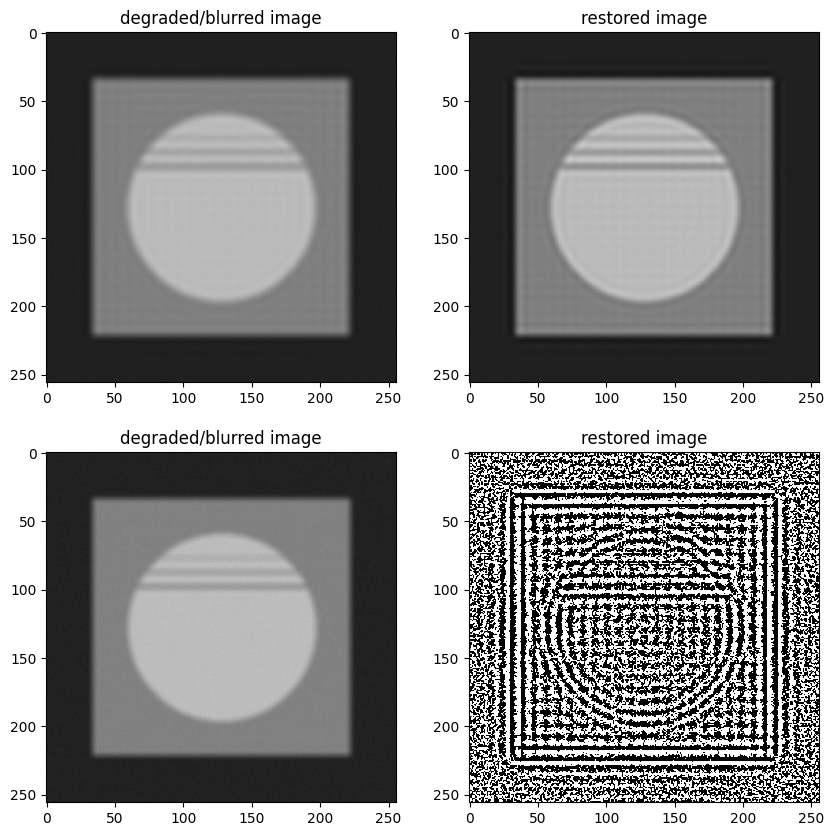

In [17]:
# Choose a value to fill the near-zero values with some constant value
Hz[np.abs(Hz)<=0.0002] = 0.0002

# Inverse filtering
Fz_hat = np.divide(Gz,Hz)
Fn_hat = np.divide(Gn,Hz)

# Inverse FFT
fz_hat = fftshift(ifftn(Fz_hat).real)
fn_hat = ifftn(Fn_hat).real

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(gz, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(222)
plt.imshow(fz_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")
plt.subplot(223)
plt.imshow(gn, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(224)
plt.imshow(fn_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")

This allows us to at least compute an estimate of the image that was convolved with a psf whose Fourier transform has zero values, however the reconstruction is suboptimal.

For the noisy image, however, the restoration is still unacceptable.

Therefore, for real cases, more knowledge should taken into consideration. Filters that are based on least squares are common in this scenario, for example the Wiener Filter and the Constrained Least Squares Filter.